In [2]:
import scanpy as sc
from SpaceFlow import SpaceFlow
import squidpy as sq
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import importlib_metadata

In [3]:
# path
data_root = Path('../data/DLPFC')

# sample name
sample_name = '151674'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7
adata = sc.read_visium(data_root / sample_name)
print(adata)
adata.var_names_make_unique()

/data/hgh/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
sf = SpaceFlow.SpaceFlow(adata=adata)

In [6]:
sf.preprocessing_data(n_top_genes=3000)

In [7]:
sf.train(spatial_regularization_strength=0.1, z_dim=50, lr=1e-3, epochs=1000, max_patience=50, min_stop=100, random_seed=42, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)

Epoch 2/1000, Loss: 1.6381937265396118
Epoch 12/1000, Loss: 1.418981909751892
Epoch 22/1000, Loss: 1.245634913444519
Epoch 32/1000, Loss: 0.8204396367073059
Epoch 42/1000, Loss: 0.5045006275177002
Epoch 52/1000, Loss: 0.3685568571090698
Epoch 62/1000, Loss: 0.25669923424720764
Epoch 72/1000, Loss: 0.18598413467407227
Epoch 82/1000, Loss: 0.1528104692697525
Epoch 92/1000, Loss: 0.12773257493972778
Epoch 102/1000, Loss: 0.11309599876403809
Epoch 112/1000, Loss: 0.10574448853731155
Epoch 122/1000, Loss: 0.09845394641160965
Epoch 132/1000, Loss: 0.08951807767152786
Epoch 142/1000, Loss: 0.09766174852848053
Epoch 152/1000, Loss: 0.07673831284046173
Epoch 162/1000, Loss: 0.06762063503265381
Epoch 172/1000, Loss: 0.07278524339199066
Epoch 182/1000, Loss: 0.06724905967712402
Epoch 192/1000, Loss: 0.06744329631328583
Epoch 202/1000, Loss: 0.059078868478536606
Epoch 212/1000, Loss: 0.055203646421432495
Epoch 222/1000, Loss: 0.059072405099868774
Epoch 232/1000, Loss: 0.05957768112421036
Epoch 242

array([[-0.05826785, -0.18900548,  0.16952746, ...,  0.82362634,
        -0.2841627 , -0.51282513],
       [ 0.9092415 , -0.67301625, -0.26123214, ..., -0.10419597,
        -0.19165643, -0.51518637],
       [ 0.74372876, -0.4644441 ,  2.3820493 , ..., -0.04695556,
        -0.59876686, -0.6340714 ],
       ...,
       [ 0.07717662, -0.48371655, -0.05729247, ..., -0.03517582,
        -0.25312594, -0.17814352],
       [-0.14981852, -0.31964973,  0.01702253, ..., -0.04022063,
        -0.21556339, -0.5485289 ],
       [ 1.755105  , -0.68487734, -0.13457015, ..., -0.10876077,
        -0.25823462, -0.5187137 ]], dtype=float32)

In [8]:
embed = pd.read_csv("./embedding.tsv", sep="\t", header=None)

# 3. 保存到 AnnData 的 obsm（常规做法）
adata.obsm["embedding"] = embed.values
os.remove("./embedding.tsv")

In [9]:
adata

AnnData object with n_obs × n_vars = 3673 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca', 'embedding'
    varm: 'PCs'

In [10]:
def res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=2023):

    for res in np.arange(0.2, 2, increment):
        sc.tl.leiden(adata, random_state=random_seed, resolution=res)
        if len(adata.obs['leiden'].unique()) > n_clusters:
            break
    return res-increment
def leiden(adata, n_clusters, use_rep=None, key_added=None, random_seed=2023):
    sc.pp.neighbors(adata, use_rep=use_rep)
    res = res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=random_seed)
    sc.tl.leiden(adata, random_state=random_seed, resolution=res)

    adata.obs[key_added] = adata.obs['leiden']
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [12]:
import importlib_metadata
adata = leiden(adata, n_clusters, use_rep='embedding', key_added='sf')

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
df_meta = pd.read_csv(data_root / sample_name / 'metadata.tsv', sep='\t')
adata.obs['Ground Truth'] = df_meta['layer_guess']

In [14]:
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['sf'], obs_df['Ground Truth'])
NMI = metrics.normalized_mutual_info_score(obs_df['sf'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.3392


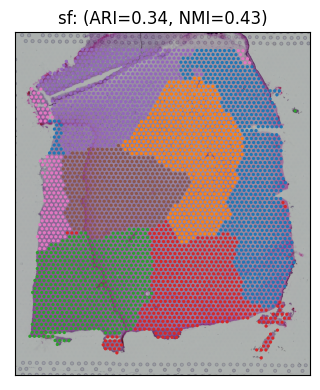

<Figure size 640x480 with 0 Axes>

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# 绘制空间数据并指定轴对象
sc.pl.spatial(
    adata,
    color="sf",
    title=('sf: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI)),
    ax=axs,
    show=False,
    legend_loc=None
)
axs.set_xlabel('')
axs.set_ylabel('')
plt.tight_layout() 
output_dir = ('./sf_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"sf_{sample_name}_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()
plt.close(fig)

In [16]:
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"151674-SpaceFlow.h5ad")
adata.write_h5ad(output_path)